## Parameters

In [1]:
from utils.dataclass import Parameters


parameters = Parameters()

## Wav 

In [2]:
from utils import wav_utils


filename = "./samples/test.wav"

sampling_rate, y = wav_utils.read_wav(filename=filename, target_sampling_rate=parameters.sampling_rate)
wav_utils.write_wav(filename="./samples/test_resampled.wav", target_sampling_rate=sampling_rate, y=y)
wav_utils.visualize_wav(y=y, sampling_rate=sampling_rate)

/home/choihk/work/github/Digital-Signal-Processing/utils/wav_utils.py:31: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, y = wavfile.read(filename=filename)


## STFT 

In [3]:
from utils import stft_utils
import torch


y_hat = stft_utils.reconstruct_wav(
    y=torch.from_numpy(y).unsqueeze(0), 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    win_length=parameters.win_length
)

wav_utils.visualize_wav(y=y_hat.squeeze(0).numpy(), sampling_rate=sampling_rate)

/home/choihk/work/github/Digital-Signal-Processing/utils/stft_utils.py:211: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:977.)
  y = torch.istft(


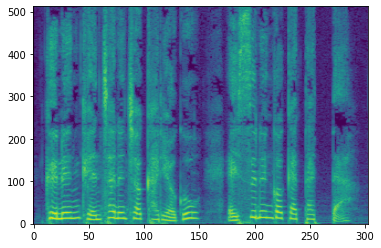

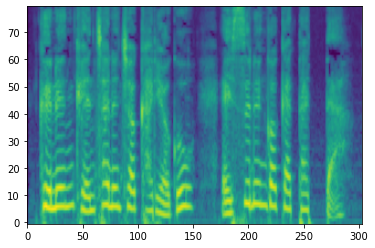

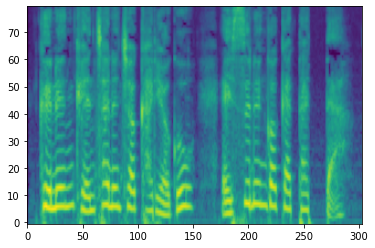

In [4]:
from utils import stft_utils
import matplotlib.pyplot as plt
import torch


linear = stft_utils.linear_spectrogram(
    y=torch.from_numpy(y).unsqueeze(0), 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    win_length=parameters.win_length, 
    epsilon=parameters.epsilon, 
    return_complex=True, 
    spectral_normalize=parameters.spectral_normalize, 
)

mel1 = stft_utils.linear_to_mel(
    y=stft_utils.denormalize(linear) if parameters.spectral_normalize else linear, 
    sampling_rate=parameters.sampling_rate, 
    n_fft=parameters.n_fft, 
    n_mel_channels=parameters.n_mel_channels, 
    epsilon=parameters.epsilon, 
    spectral_normalize=parameters.spectral_normalize, 
)

mel2 = stft_utils.mel_spectrogram(
    y=torch.from_numpy(y).unsqueeze(0), 
    sampling_rate=parameters.sampling_rate, 
    n_mel_channels=parameters.n_mel_channels, 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    win_length=parameters.win_length, 
    epsilon=parameters.epsilon, 
    return_complex=True, 
    spectral_normalize=parameters.spectral_normalize, 
)


plt.imshow(linear.squeeze(0).numpy(), origin='lower', aspect='auto')
plt.show()

plt.imshow(mel1.squeeze(0).numpy(), origin='lower', aspect='auto')
plt.show()

plt.imshow(mel2.squeeze(0).numpy(), origin='lower', aspect='auto')
plt.show()

## Linear Predictive Coding

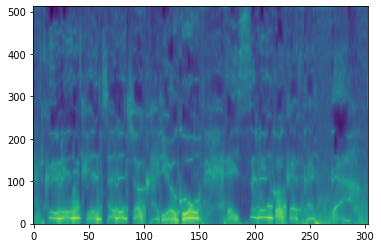

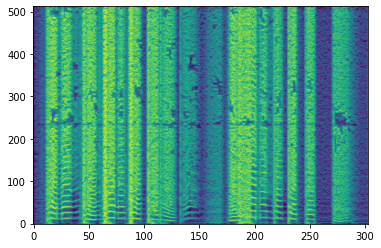

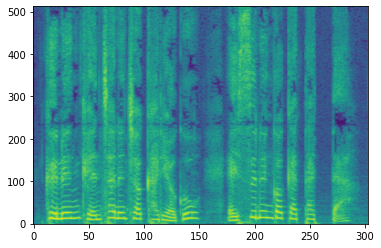

In [5]:
from utils import stft_utils, lpc_utils
import matplotlib.pyplot as plt
import torch


fft = stft_utils.stft(
    torch.from_numpy(y).unsqueeze(0), 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    return_complex=True
)

fft_hat, source, envelope = lpc_utils.reconstruct_fft(
    fft=fft, 
    n_code_channels=parameters.n_code_channels, 
    win_length=parameters.win_length, 
    epsilon=parameters.epsilon, 
    return_complex=False
)

plt.imshow(stft_utils.normalize(envelope[0]).detach().cpu().numpy(), origin='lower', aspect='auto')
plt.show()

plt.imshow(stft_utils.normalize(source[0]).detach().cpu().numpy(), origin='lower', aspect='auto')
plt.show()

plt.imshow(stft_utils.normalize(fft_hat[0]).detach().cpu().numpy(), origin='lower', aspect='auto')
plt.show()

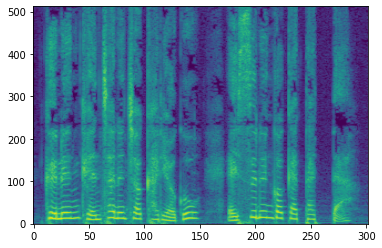

In [6]:
from utils import stft_utils, lpc_utils
import matplotlib.pyplot as plt
import torch


fft = stft_utils.stft(
    torch.from_numpy(y).unsqueeze(0), 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    return_complex=True
)

fft_hat, source, envelope = lpc_utils.reconstruct_fft(
    fft=fft, 
    n_code_channels=parameters.n_code_channels, 
    win_length=parameters.win_length, 
    epsilon=parameters.epsilon, 
    return_complex=True
)

fft_hat = torch.cat([torch.real(fft_hat)[...,None], torch.imag(fft_hat)[...,None]], dim=-1)

y_hat = stft_utils.istft(
    y=fft_hat, 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    win_length=parameters.win_length 
)

linear = stft_utils.linear_spectrogram(
    y=y_hat, 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    win_length=parameters.win_length, 
    epsilon=parameters.epsilon, 
    spectral_normalize=parameters.spectral_normalize, 
)


plt.imshow(linear[0].detach().cpu().numpy(), origin='lower', aspect='auto')
plt.show()

wav_utils.visualize_wav(y=y_hat.squeeze(0).numpy(), sampling_rate=sampling_rate)

## Source Envelope Augmentation

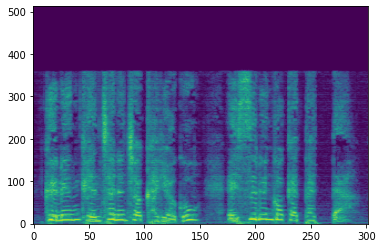

In [7]:
from utils import stft_utils, lpc_utils, interpolation_utils
import matplotlib.pyplot as plt
import torch


source_scale_factor = 0.8
envelope_scale_factor = 0.7
mode = "linear"


fft = stft_utils.stft(
    torch.from_numpy(y).unsqueeze(0), 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    return_complex=True
)

_, source, envelope = lpc_utils.reconstruct_fft(
    fft=fft, 
    n_code_channels=parameters.n_code_channels, 
    win_length=parameters.win_length, 
    epsilon=parameters.epsilon, 
    return_complex=True
)

source_aug = interpolation_utils.interpolate(source, scale_factor=source_scale_factor, mode=mode)
envelope_aug = interpolation_utils.interpolate(envelope, scale_factor=envelope_scale_factor, mode=mode)
fft_aug = source_aug * envelope_aug

fft_aug_hat = torch.cat([torch.real(fft_aug)[...,None], torch.imag(fft_aug)[...,None]], dim=-1)

y_aug_hat = stft_utils.istft(
    y=fft_aug_hat, 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    win_length=parameters.win_length 
)

linear_aug = stft_utils.linear_spectrogram(
    y=y_aug_hat, 
    n_fft=parameters.n_fft, 
    hop_length=parameters.hop_length, 
    win_length=parameters.win_length, 
    epsilon=parameters.epsilon, 
    spectral_normalize=parameters.spectral_normalize, 
)


plt.imshow(linear_aug[0].detach().cpu().numpy(), origin='lower', aspect='auto')
plt.show()

wav_utils.visualize_wav(y=y_aug_hat.squeeze(0).numpy(), sampling_rate=sampling_rate, normalize=True)